# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (3/3), done.


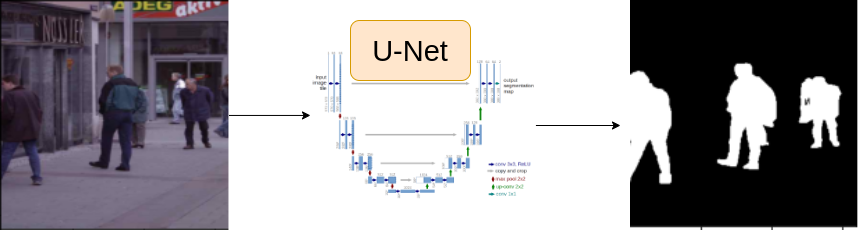

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [42]:
#get the second iamge at position 1 for visualization
row = df.iloc[1]

image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

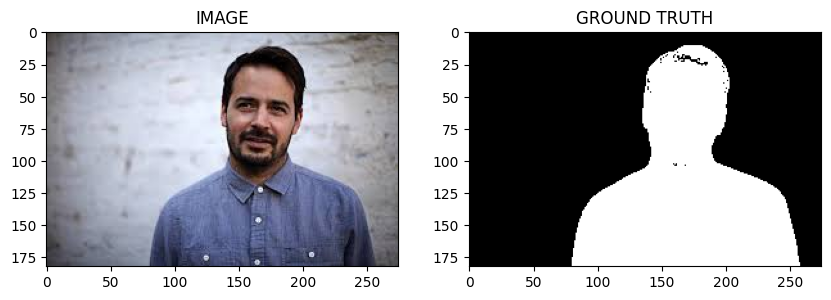

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [13]:
# split the dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [14]:
# import library for augmentation
import albumentations as A

In [15]:
# function for training dataset augmentation
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])


# function for validation dataset augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [16]:
from torch.utils.data import Dataset


In [17]:
class SegmentationDataset(Dataset):

  # the initial method for the dataframe and augmentation
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  # length of the dataframe
  def __len__(self):
    return len(self.df)

  # get item the image attributes
  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    data = self.augmentations(image=image, mask=mask)
    image = data['image']
    mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)


    # convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [18]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [19]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


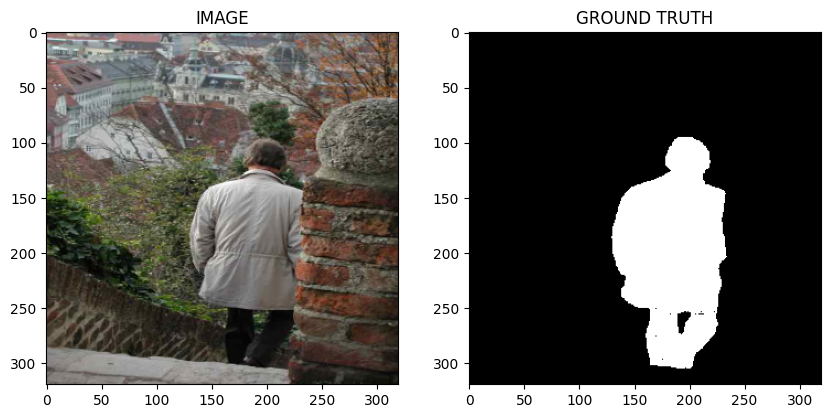

In [21]:
idx = 7

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [22]:
from torch.utils.data import DataLoader


In [23]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [24]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [25]:
for image, mask in trainloader:
  break
print(f"Image shape : {image.shape}")
print(f"Mask shape : {mask.shape}")

Image shape : torch.Size([16, 3, 320, 320])
Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [26]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [27]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):

    logits = self.arc(images)

    if mask is not None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [28]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 23.9MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [29]:
def train_fn(model, dataloader, optimizer):
  model.train()
  train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    optimizer.step()
    train_loss += loss.item()

    total_loss = train_loss / len(dataloader)
  return total_loss

In [30]:
def eval_fn(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [32]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


SAVED-MODEL
EPOCH : 1 | Train Loss : 1.4708040873209636 | Valid Loss : 1.3282006978988647


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


EPOCH : 2 | Train Loss : 1.464574646949768 | Valid Loss : 1.3691674172878265


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


EPOCH : 3 | Train Loss : 1.4664144436518352 | Valid Loss : 1.4206499755382538


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


EPOCH : 4 | Train Loss : 1.469015653928121 | Valid Loss : 1.442255288362503


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


EPOCH : 5 | Train Loss : 1.4716689904530844 | Valid Loss : 1.4454558789730072


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


EPOCH : 6 | Train Loss : 1.4679665486017863 | Valid Loss : 1.4498251378536224


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


EPOCH : 7 | Train Loss : 1.465997338294983 | Valid Loss : 1.4450757503509521


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


EPOCH : 8 | Train Loss : 1.4674173275629678 | Valid Loss : 1.4430033266544342


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


EPOCH : 9 | Train Loss : 1.4739359537760417 | Valid Loss : 1.4426392018795013


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


EPOCH : 10 | Train Loss : 1.46897611618042 | Valid Loss : 1.44208163022995


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


EPOCH : 11 | Train Loss : 1.4752923885981242 | Valid Loss : 1.4457567930221558


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


EPOCH : 12 | Train Loss : 1.471226970354716 | Valid Loss : 1.4470678567886353


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


EPOCH : 13 | Train Loss : 1.4632467110951741 | Valid Loss : 1.4457983076572418


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


EPOCH : 14 | Train Loss : 1.470646365483602 | Valid Loss : 1.4463048577308655


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


EPOCH : 15 | Train Loss : 1.468838087717692 | Valid Loss : 1.4455932676792145


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


EPOCH : 16 | Train Loss : 1.472368597984314 | Valid Loss : 1.447472631931305


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


EPOCH : 17 | Train Loss : 1.4664920806884765 | Valid Loss : 1.4503728151321411


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


EPOCH : 18 | Train Loss : 1.471912638346354 | Valid Loss : 1.447639524936676


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


EPOCH : 19 | Train Loss : 1.474157444636027 | Valid Loss : 1.4459595382213593


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


EPOCH : 20 | Train Loss : 1.4726394176483155 | Valid Loss : 1.448449432849884


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


EPOCH : 21 | Train Loss : 1.469285496075948 | Valid Loss : 1.450060248374939


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


EPOCH : 22 | Train Loss : 1.4684418121973672 | Valid Loss : 1.4497076570987701


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


EPOCH : 23 | Train Loss : 1.4711421251296997 | Valid Loss : 1.450266718864441


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


EPOCH : 24 | Train Loss : 1.4676488955815634 | Valid Loss : 1.4433141350746155


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

EPOCH : 25 | Train Loss : 1.4775405406951905 | Valid Loss : 1.4440549612045288


# Task 9 : Inference

In [33]:
def inference(indx):
  idx = indx

  model.load_state_dict(torch.load('/content/best_model.pth'))

  image, mask = validset[idx]


  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

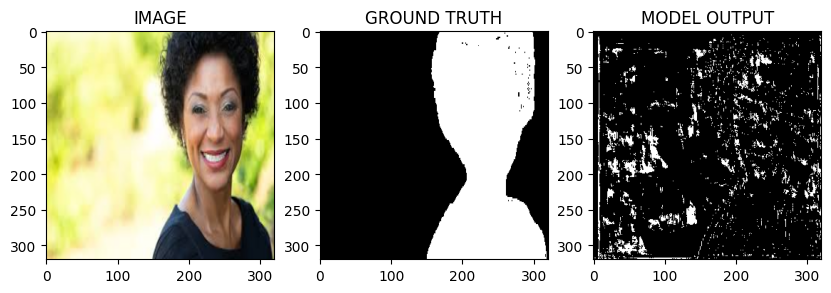

In [39]:
inference(2)
